In [10]:
import OpenEXR
import Imath
import array
import numpy as np
import csv
import time
import datetime
import h5py
import matplotlib.pyplot as plt
import cv2

The next snippet is used to plot the depth calculated in the script


In [7]:
def exr2depth(exr, maxvalue=1.,normalize=True):
    """ converts 1-channel exr-data to 2D numpy arrays """                                                                    
    file = OpenEXR.InputFile(exr)

    # Compute the size
    dw = file.header()['dataWindow']
    sz = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    # Read the three color channels as 32-bit floats
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    (R) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in "R" ]

    # create numpy 2D-array
    img = np.zeros((sz[1], sz[0], 3), np.float64)

    # normalize
    data = np.array(R)
    data[data > maxvalue] = maxvalue

    if normalize:
        data /= np.max(data)

    img = np.array(data).reshape(img.shape[0],-1)

    return img

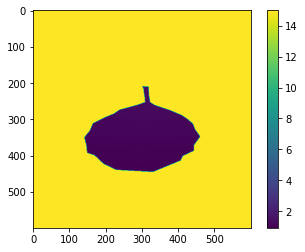

In [14]:
depth_data = exr2depth("output/alder_leaf_render_0_0_0_depth0001.exr", maxvalue=15, normalize=False)

fig = plt.figure()
plt.imshow(depth_data)
plt.colorbar()
plt.show()

The next snippet is used to plot the flow

In [12]:
def exr2flow(exr):
  file = OpenEXR.InputFile(exr)

  # Compute the size
  dw = file.header()['dataWindow']
  sz = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

  FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
  (R,G,B) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in ("R", "G", "B") ]

  img = np.zeros((sz[1], sz[0], 3), np.float64)
  img[:,:,0] = np.array(R).reshape(img.shape[0],-1)
  img[:,:,1] = -np.array(G).reshape(img.shape[0],-1)

  hsv = np.zeros((sz[1], sz[0], 3), np.uint8)
  hsv[...,1] = 255

  mag, ang = cv2.cartToPolar(img[...,0], img[...,1])
  hsv[...,0] = ang*180/np.pi/2
  hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
  bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

  return img, bgr, mag, ang

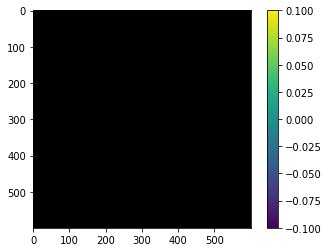

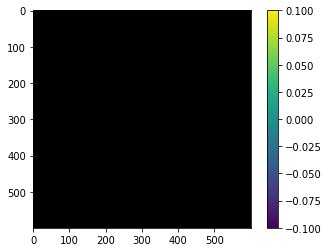

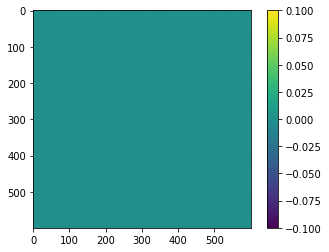

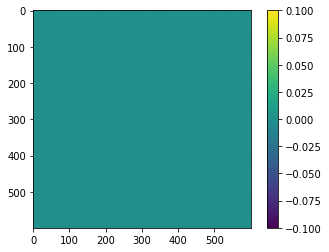

In [16]:
flow_data = exr2flow("output/alder_leaf_render_0_0_0_optical-flow0001.exr")

for data in flow_data:
  fig = plt.figure()
  plt.imshow(data)
  plt.colorbar()
  plt.show()

The next snippet is used to plot exr images


In [18]:
def exr2img(exr):
  file = OpenEXR.InputFile(exr)

  # Compute the size
  dw = file.header()['dataWindow']
  sz = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

  FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
  (R,G,B) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in ("R", "G", "B") ]

  img = np.zeros((sz[1], sz[0], 3), np.float64)
  img[:,:,0] = np.array(R).reshape(img.shape[0],-1)
  img[:,:,1] = np.array(G).reshape(img.shape[0],-1)
  img[:,:,2] = np.array(B).reshape(img.shape[0],-1)

  return img

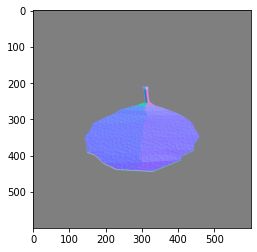

In [19]:
nrm_data = exr2img("output/alder_leaf_render_0_0_0_normal0001.exr")

fig = plt.figure()
plt.imshow(nrm_data)
plt.show()

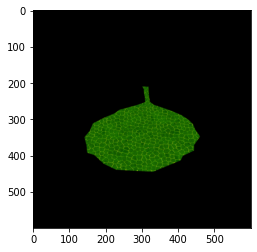

In [20]:
albedo_data = exr2img("output/alder_leaf_render_0_0_0_albedo0001.exr")

fig = plt.figure()
plt.imshow(albedo_data)
plt.show()